## **Natural Language Processing with Disaster Tweets**


In this analysis, the dataset containing disaster and non-disaster tweets is explored through various visualizations, including countplots, bar charts, word clouds, and heatmaps. The data is preprocessed and cleaned by removing URLs, mentions, hashtags, and stopwords. Then, features such as text length, word count, and the frequency of specific words are extracted. The dataset is further processed by applying target encoding on the 'keyword' column and using TfidfVectorizer for text features. A logistic regression model is trained, and its performance is evaluated using cross-validation and F1 scores. Feature selection is performed using RFECV to determine the optimal number of features for the model.


### **Importing libraries and data**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string

In [3]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### **Data Cleaning**
Let's start by understanding the structure and content of our data.

We need to perform data cleaning on the text data in a df to standardize its format and remove any extraneous information that may not be relevant to the analysis. This is important because it helps to ensure that the machine learning models are working with consistent and reliable inputs. Specifically, we are creating a "clean_text" column in the DataFrame that removes links and unnecessary white spaces from the text in the "text" column. By doing so, we are improving the quality of the data and making it easier to analyze and interpret, which ultimately leads to more accurate and reliable results in natural language processing tasks such as sentiment analysis, classification, and topic modeling.

In [6]:
train_df.info

<bound method DataFrame.info of          id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...

In [9]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

There's a lot of null values in our locations column, let's go ahead and try dropping this column.

In [11]:
train = train_df.drop(columns=['location'])
test = test_df.drop(columns=['location'])
train.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Now let's clean the strings up to remove any links, line breaks, or extra spaces.

In [44]:
import re

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove links
    text = re.sub(r'\n', ' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

Let's text out our function on a sample text.

In [45]:
sample_text = train.loc[812, 'text']
print("Original text: " + sample_text)
print("Cleaned text: " + clean_text(sample_text))

Original text: What if every 5000 wins in ranked play gave you a special card back.. Would be cool for the long teÛ_ http://t.co/vq3yaB2j8N
Cleaned text: What if every 5000 wins in ranked play gave you a special card back.. Would be cool for the long teÛ_


### **Feature Engineering**

This code is performing data preprocessing and feature engineering by extracting hashtags, mentions, and links from tweets and creating new columns in a DataFrame to store this information. By doing so, it adds valuable information to our dataset that can be used as features for machine learning models to improve their performance in various natural language processing tasks such as sentiment analysis, social network analysis, topic modeling, content analysis, and identifying relevant news sources. This process helps to enrich our dataset with additional information that can improve the accuracy and reliability of machine learning models.

In [77]:
# Define functions to extract hashtags, mentions, and links from a tweet
def extract_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def extract_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def extract_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

# Define a function to process the text data in a DataFrame
def process_text_data(df):
    # Clean the text in each tweet
    
    df['clean_text'] = df['text'].apply(lambda x: clean_text(x))
    # Extract hashtags, mentions, and links from each tweet and add them as new columns in the DataFrame
    df['hashtags'] = df['text'].apply(lambda x: extract_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: extract_mentions(x))
    df['links'] = df['text'].apply(lambda x: extract_links(x))
    return df

# Apply the text processing function to the training and testing datasets
train = process_text_data(train)
test = process_text_data(test)

Let's add features. By creating additional features like tweet length, word count, stopword count, count of mentions, links, hashtags, punctuation, and count of uppercase letters, we can extract more information from the text data. These features may help in improving the predictive power of the machine learning models and can provide insights into the structure and characteristics of the tweets.

In [77]:
from wordcloud import STOPWORDS

def create_stat(df):
    # Tweet length
    df['text_len'] = df['clean_text'].apply(len)
    # Word count
    df['word_count'] = df["clean_text"].apply(lambda x: len(str(x).split()))
    # Stopword count
    df['stop_word_count'] = df['clean_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    # Count of mentions (@)
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    # Count of links
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    # Count of hashtags (#)
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
    # Punctuation count
    df['punctuation_count'] = df['clean_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # Count of uppercase letters
    df['caps_count'] = df['clean_text'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Ratio of uppercase letters
    df['caps_ratio'] = df['caps_count'] / df['text_len']
    return df

train = create_stat(train)
test = create_stat(test)

# Display the first few rows of the processed training dataset
train.head()

,id,keyword,text,target,clean_text,hashtags,mentions,links,text_len,word_count,stop_word_count,hashtag_count,punctuation_count,mention_count,link_count,caps_count,caps_ratio
0,1,o f,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,earthquake,no,no,69,13,6,1,1,1,1,10,0.144928
1,4,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,no,no,no,38,7,0,1,1,1,1,5,0.131579
2,5,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,no,no,no,133,22,11,1,3,1,1,2,0.015038
3,6,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",wildfires,no,no,64,8,1,1,2,1,1,1,0.015625
4,7,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Alaska wildfires,no,no,87,16,7,2,2,1,1,3,0.034483


**Missing Keywords**

Filling in missing values in a DataFrame is an important step in data preprocessing because many machine learning algorithms cannot handle missing data. In the case of the "keyword" column in the disaster tweets dataset, missing values can occur for various reasons, such as data entry errors or incomplete information.

By filling in the missing values in the "keyword" column using a BERT model for text analysis, we can provide relevant information to machine learning models that can improve their performance in predicting whether a given tweet is about a real disaster or not. This can help to produce more accurate and reliable results in natural language processing tasks such as sentiment analysis, classification, and topic modeling.

In [47]:
import transformers
import torch

# Instantiate the BERT tokenizer and model
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

# Define a function to extract keywords from text using the BERT model
def extract_keywords(text):
    tokens = tokenizer.encode(text, add_special_tokens=True)
    if len(tokens) == 0:
        return []
    input_ids = torch.tensor([tokens])
    with torch.no_grad():
        outputs = model(input_ids)
        embeddings = outputs.last_hidden_state[0]
    sentence_embedding = torch.sum(embeddings, dim=0)
    if len(sentence_embedding) < 3:
        num_keywords = len(sentence_embedding)
    else:
        num_keywords = 3
    keywords = []
    for i in sentence_embedding.argsort()[-num_keywords:]:
        if i >= len(tokens):
            continue
        keywords.append(tokenizer.decode(tokens[i]))
    return keywords[::-1]

# Fill in missing values in "keyword" column using BERT
for i in range(len(train)):
    if pd.isnull(train.loc[i, 'keyword']):
        keywords = extract_keywords(train.loc[i, 'clean_text'])
        train.loc[i, 'keyword'] = ', '.join(keywords)
for i in range(len(test)):
    if pd.isnull(test.loc[i, 'keyword']):
        keywords = extract_keywords(test.loc[i, 'clean_text'])
        test.loc[i, 'keyword'] = ', '.join(keywords)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [48]:
train.isnull().sum()
train.head()

,id,keyword,text,target,clean_text,hashtags,mentions,links
0,1,o f,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,earthquake,no,no
1,4,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,no,no,no
2,5,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,no,no,no
3,6,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",wildfires,no,no
4,7,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Alaska wildfires,no,no


### **Visualizing the Data**

**Countplot**

The sns.countplot is a useful visualization tool for exploring the distribution of categorical data. In this case, we use it to visualize the distribution of disaster and non-disaster tweets in the training dataset. The countplot displays the number of tweets in each category, which helps us understand the class balance of our dataset and detect any potential class imbalance issues.

0    4342
1    3271
Name: target, dtype: int64


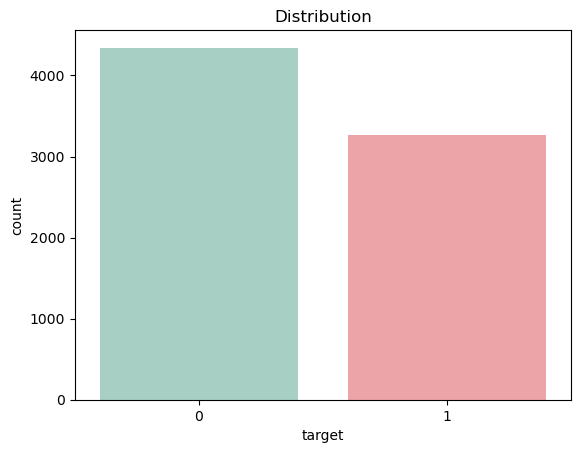

In [61]:
sns.set_palette(['#a2d5c6', '#f9989f'])
sns.countplot(x='target', data=train)
plt.title('Distribution');
print(train['target'].value_counts())

**Bar Chart**

We use a bar chart as a simple way to visualize the distribution of a categorical variable. It is useful for comparing the frequencies of different categories and identifying which categories are most common.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


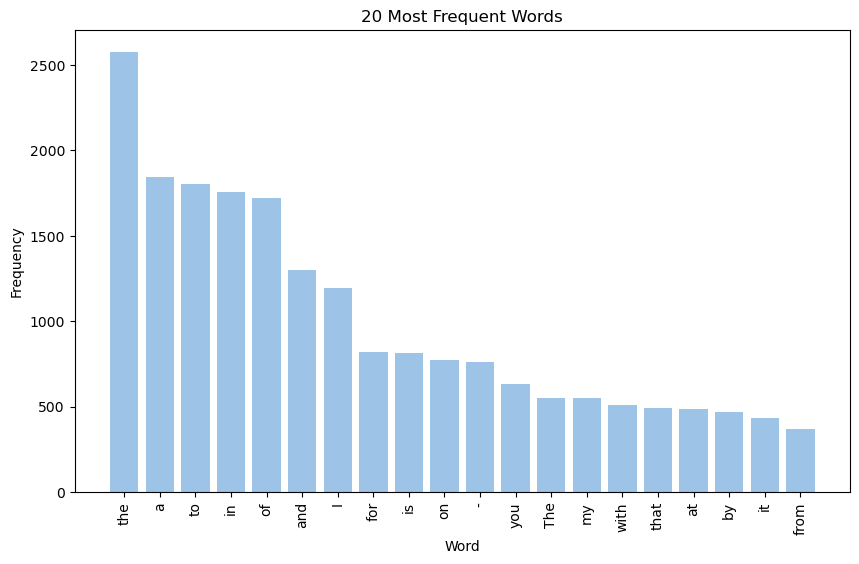

In [62]:
import collections

# Combine all the cleaned tweet text into a single string
all_text = ' '.join(train['clean_text'].tolist())

# Split the text into individual words
words = all_text.split()

# Count the frequency of each word
word_counts = collections.Counter(words)

# Get the 20 most frequent words
top_words = word_counts.most_common(20)

# Create and display the bar plot
fig, ax = plt.subplots(figsize=(10,6))
ax.bar([word[0] for word in top_words], [word[1] for word in top_words], color='#9dc3e6')
ax.set_xticklabels([word[0] for word in top_words], rotation=90)
ax.set_title('20 Most Frequent Words')
ax.set_xlabel('Word')
ax.set_ylabel('Frequency')
plt.show()


Hmm. That wasn't very helpful. Let's take a look at frequent keywords instead.

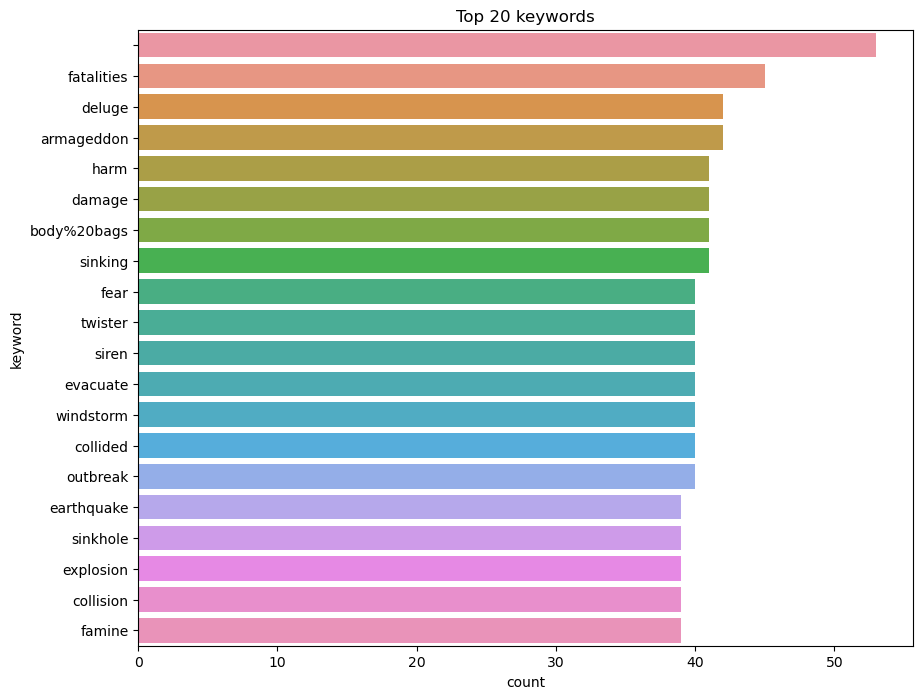

In [72]:
plt.figure(figsize=(10,8))
sns.countplot(y=train.keyword, order = train.keyword.value_counts().iloc[:20].index)
plt.title('Top 20 keywords')
plt.show()

**Word Cloud**

We use a word cloud as a visual representation of the most frequently occurring words in a text. It is useful for identifying patterns in the text and can be used to get a quick understanding of the topics that are being discussed.

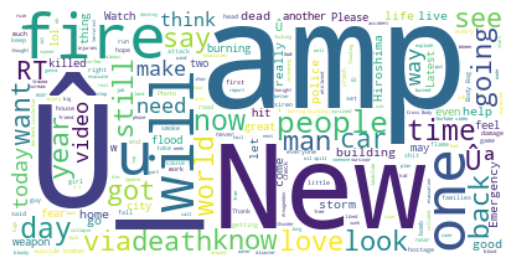

In [55]:
from wordcloud import WordCloud

# Combine all the cleaned tweet text into a single string
all_text = ' '.join(train['clean_text'].tolist())

# Create and display the word cloud
wordcloud = WordCloud(background_color='white').generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Histogram of Tweet Lengths**

We use a histogram as a graphical representation of the distribution of a continuous variable. It is useful for visualizing the shape of the data, identifying the central tendency, and identifying any outliers or unusual patterns in the data.

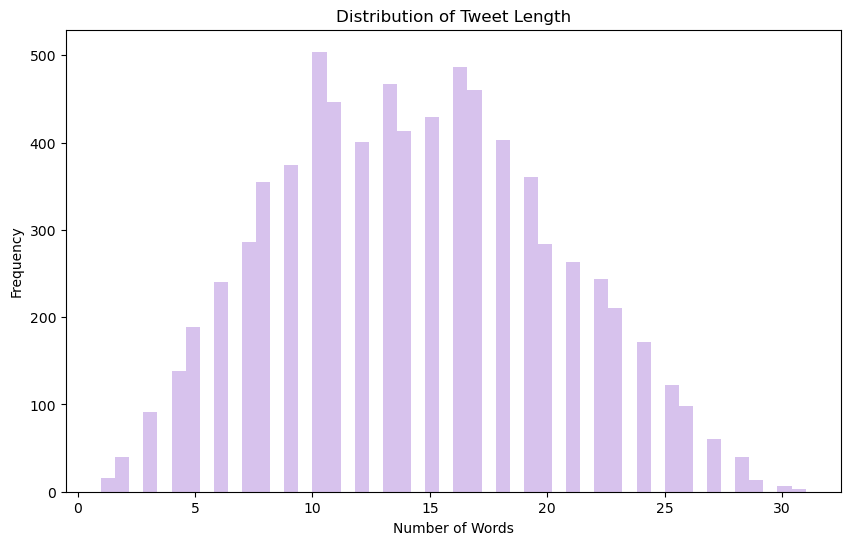

In [63]:
# Get the length of each cleaned tweet
tweet_lengths = [len(tweet.split()) for tweet in train['clean_text']]

# Create and display the histogram
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(tweet_lengths, bins=50, color='#c7a9e6', alpha=0.7)
ax.set_title('Distribution of Tweet Length')
ax.set_xlabel('Number of Words')
ax.set_ylabel('Frequency')
plt.show()


**Heatmap**

The visualization showing the correlation coefficients between the target variable and the additional features gives us an idea of which features are most strongly related to whether a tweet is about a real disaster or not. This can help us identify the most important features to include in our models for predicting the target variable.

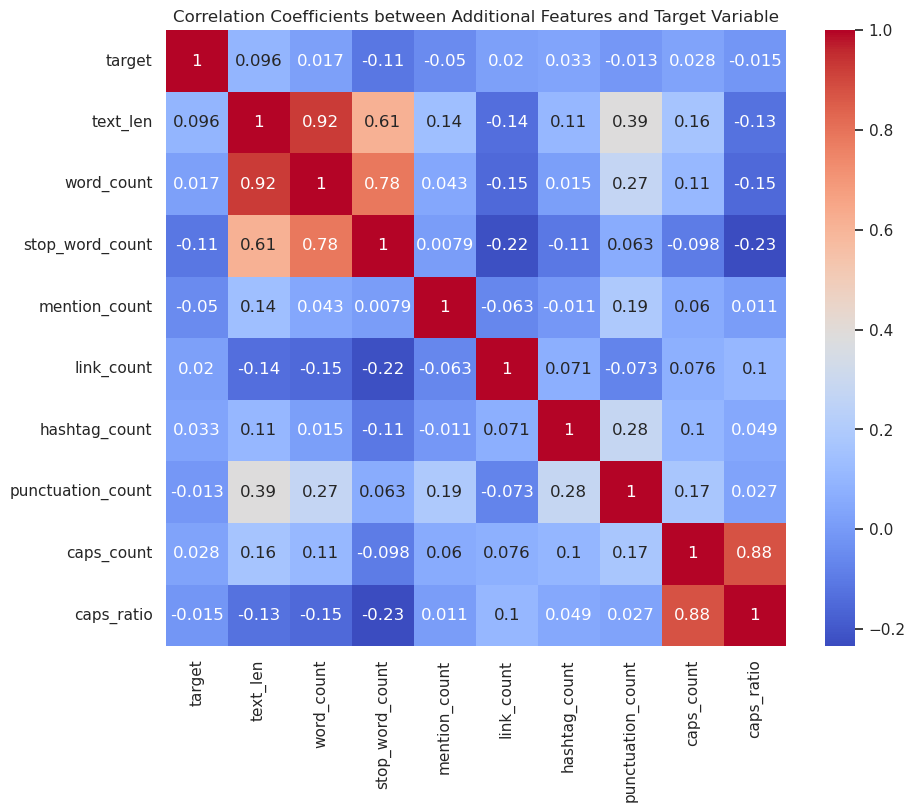

In [82]:
# Select the columns of interest
cols_of_interest = ['target', 'text_len', 'word_count', 'stop_word_count', 'mention_count', 'link_count', 'hashtag_count', 'punctuation_count', 'caps_count', 'caps_ratio']
df = train[cols_of_interest]

# Compute the correlation matrix
corr_matrix = df.corr()

# Create the heatmap
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Coefficients between Additional Features and Target Variable')
plt.show()

In [84]:
train.corr()['target'].drop('target').sort_values()

stop_word_count     -0.111250
mention_count       -0.049654
caps_ratio          -0.014970
punctuation_count   -0.012535
word_count           0.017081
link_count           0.020244
caps_count           0.027808
hashtag_count        0.032853
id                   0.060781
text_len             0.096435
Name: target, dtype: float64

**Word Frequencies Cont.**

We can now generate a bar plot of the top 20 most common words in the cleaned tweet text from the train dataframe, allowing us to gain insight into the most frequently used words in the dataset.

In [ ]:
from nltk import FreqDist, word_tokenize

# Make a set of stop words
stopwords = set(STOPWORDS)

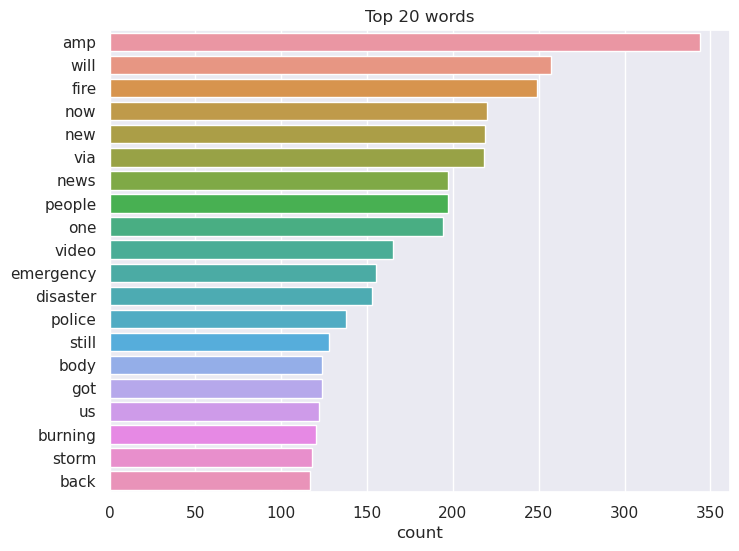

In [87]:
word_freq = FreqDist(w for w in word_tokenize(' '.join(train['clean_text']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))

#Creation a DataFrame from the frequency distribution and selects the top 20 most common words
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count',ascending=False).head(20)

#Creation a bar plot of the top 20 words using the Seaborn library
plt.figure(figsize=(8,6))
sns.barplot(x='count', y=top20w.index, data=top20w)
plt.title('Top 20 words')
plt.show()

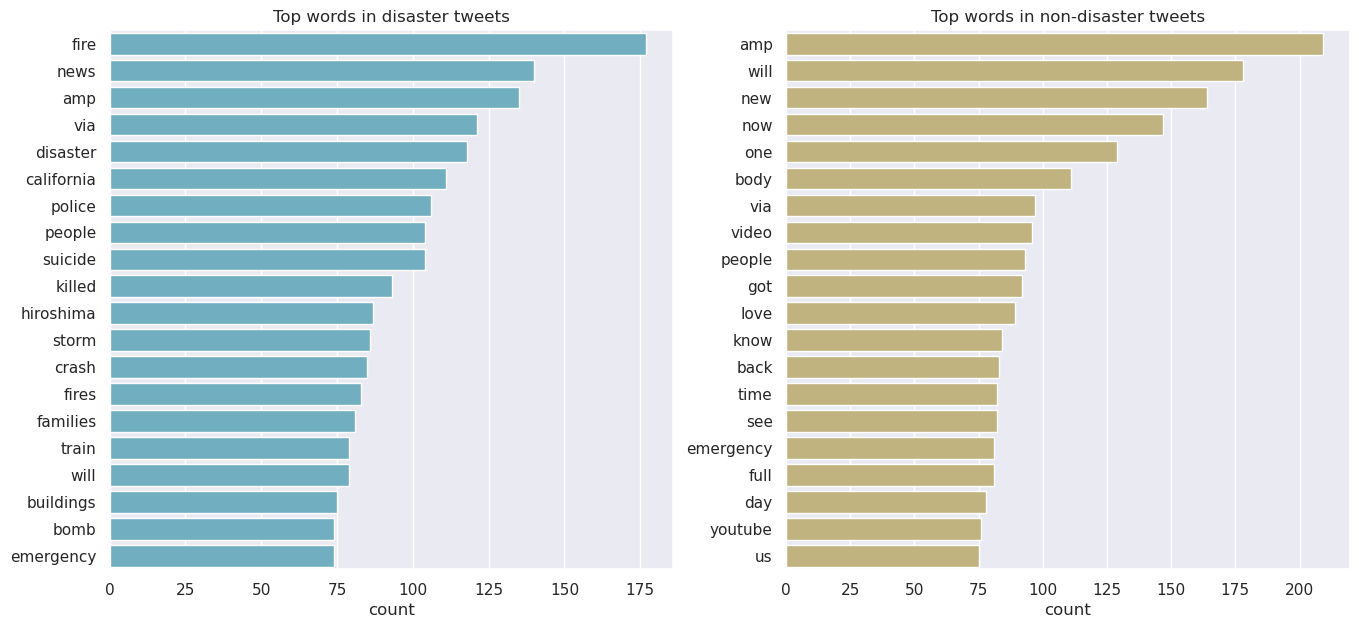

In [90]:
plt.figure(figsize=(16,7))

plt.subplot(121)

freq_d = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==1, 'clean_text']).lower()) if
(w not in stopwords) & (w.isalpha()))

df_d = pd.DataFrame.from_dict(freq_d, orient='index', columns=['count'])

top20_d = df_d.sort_values('count',ascending=False).head(20)

sns.barplot(x='count', y=top20_d.index, data=top20_d, color='c')

plt.title('Top words in disaster tweets')

plt.subplot(122)

freq_nd = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==0, 'clean_text']).lower()) if
(w not in stopwords) & (w.isalpha()))

df_nd = pd.DataFrame.from_dict(freq_nd, orient='index', columns=['count'])

top20_nd = df_nd.sort_values('count',ascending=False).head(20)

sns.barplot(x='count', y=top20_nd.index, data=top20_nd, color='y')

plt.title('Top words in non-disaster tweets')

plt.show()

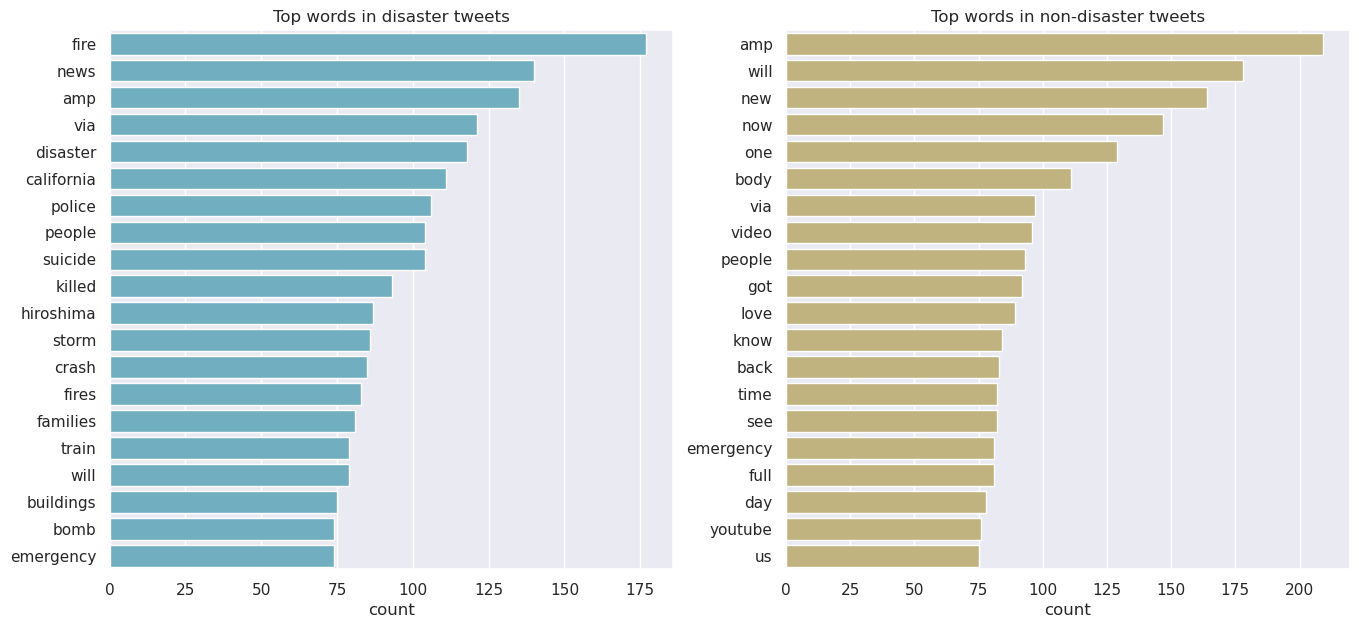

#### **Encoding/Vectorization**

This code aims to create CountVectorizer objects for 'links', 'mentions', and 'hashtags' columns in train and test datasets, filtering out any with less than 5 occurrences, transforming them into DataFrames and printing their shapes to verify the encoding was successful.

The following code then calculates the proportion of disaster tweets containing a link for each link feature, and displays the percentage using a barplot sorted in descending order. A vertical line is added to indicate the average value of the target variable, and the plot is titled "% of disaster tweets given links".

In [92]:
import category_encoders as ce

# Target encoding
# Specify the column(s) to encode
features = ['keyword']

# Create a target encoder object
encoder = ce.TargetEncoder(cols=features)

# Fit the encoder on the training set
encoder.fit(train[features], train['target'])

# Apply the encoding to both the training and test sets and add suffix "_target" to the new columns
train = train.join(encoder.transform(train[features]).add_suffix('_target'))
test = test.join(encoder.transform(test[features]).add_suffix('_target'))
train.head(3)

,id,keyword,text,target,clean_text,hashtags,mentions,links,text_len,word_count,stop_word_count,hashtag_count,punctuation_count,mention_count,link_count,caps_count,caps_ratio,keyword_target
0,1,o f,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,earthquake,no,no,69,13,6,1,1,1,1,10,0.144928,0.503866
1,4,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,no,no,no,38,7,0,1,1,1,1,5,0.131579,0.652170
2,5,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,no,no,no,133,22,11,1,3,1,1,2,0.015038,0.652170


The following code calculates the proportion of disaster tweets containing a link for each link feature, and displays the percentage using a barplot sorted in descending order. A vertical line is added to indicate the average value of the target variable, and the plot is titled "% of disaster tweets given links".

In [93]:
from sklearn.feature_extraction.text import CountVectorizer

vec_links = CountVectorizer(min_df=5, analyzer='word', token_pattern=r'https?://\S+')
link_vec = vec_links.fit_transform(train['links'])  # Fit and transform the train data
link_vec_test = vec_links.transform(test['links'])   # Transform the test data using the same vocabulary
X_train_link = pd.DataFrame(link_vec.toarray(), columns=vec_links.get_feature_names())  # Convert the sparse matrix to DataFrame
X_test_link = pd.DataFrame(link_vec_test.toarray(), columns=vec_links.get_feature_names())

vec_men = CountVectorizer(min_df=5)
men_vec = vec_men.fit_transform(train['mentions'])  # Fit and transform the train data
men_vec_test = vec_men.transform(test['mentions'])   # Transform the test data using the same vocabulary
X_train_men = pd.DataFrame(men_vec.toarray(), columns=vec_men.get_feature_names())  # Convert the sparse matrix to DataFrame
X_test_men = pd.DataFrame(men_vec_test.toarray(), columns=vec_men.get_feature_names())

vec_hash = CountVectorizer(min_df=5)
hash_vec = vec_hash.fit_transform(train['hashtags'])  # Fit and transform the train data
hash_vec_test = vec_hash.transform(test['hashtags'])   # Transform the test data using the same vocabulary
X_train_hash = pd.DataFrame(hash_vec.toarray(), columns=vec_hash.get_feature_names())  # Convert the sparse matrix to DataFrame
X_test_hash = pd.DataFrame(hash_vec_test.toarray(), columns=vec_hash.get_feature_names())

print(X_train_link.shape, X_train_men.shape, X_train_hash.shape)

(7613, 6) (7613, 18) (7613, 107)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The following code uses the TfidfVectorizer to create a sparse matrix of text features with a minimum document frequency of 10 and a range of unigrams and bigrams, and then transforms the train and test data into sparse matrices of these features, and prints the shape of the train matrix.

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec_text = TfidfVectorizer(min_df=10, ngram_range=(1, 2), stop_words='english')

text_vec = vec_text.fit_transform(train['clean_text'])
text_vec_test = vec_text.transform(test['clean_text'])

X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())

print(X_train_text.shape)

(7613, 1691)


We can then join our dataframes together.

In [96]:
train = train.join(X_train_link, rsuffix='_link')
train = train.join(X_train_men, rsuffix='_mention')
train = train.join(X_train_hash, rsuffix='_hashtag')
train = train.join(X_train_text, rsuffix='_text')
test = test.join(X_test_link, rsuffix='_link')
test = test.join(X_test_men, rsuffix='_mention')
test = test.join(X_test_hash, rsuffix='_hashtag')
test = test.join(X_test_text, rsuffix='_text')
print (train.shape, test.shape)

(7613, 1840) (3263, 1839)


### **Machine Learning Modeling**

Time to train the models.

In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Initializing the model, scalar
features_to_drop = ['id', 'keyword','text','clean_text', 'hashtags', 'mentions','links']
scaler = MinMaxScaler()
X_train = train.drop(columns=features_to_drop + ['target'])
y_train = train['target']

# Creating the pipeline
X_test = test.drop(columns=features_to_drop)
lr = LogisticRegression(solver='liblinear', random_state=777)
pipeline = Pipeline([('scale',scaler), ('lr', lr)])
pipeline.fit(X_train, y_train)
y_test = pipeline.predict(X_test)
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submit = sample_submission.copy()
submit.target = y_test
submit.to_csv('submit_lr.csv', index=False)

Let's take a look now at our training accuracy along with a confusion matrix and cross validation scoring.

In [105]:
from sklearn.metrics import f1_score

print('Training accuracy: %.4f and Training f-1 score: %.4f' %
(pipeline.score(X_train, y_train), f1_score(y_train, pipeline.predict(X_train))))

Training accuracy: 0.8541 and Training f-1 score: 0.8194


In [102]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_train, pipeline.predict(X_train)))

,0,1
0,3981,361
1,750,2521


In [103]:
# Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=123)
cv_score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
print('Cross validation F-1 score: %.3f' %np.mean(cv_score))

Cross validation F-1 score: 0.755


Let's now take a look at some of our top features along with an analysis on the feature selection itself.

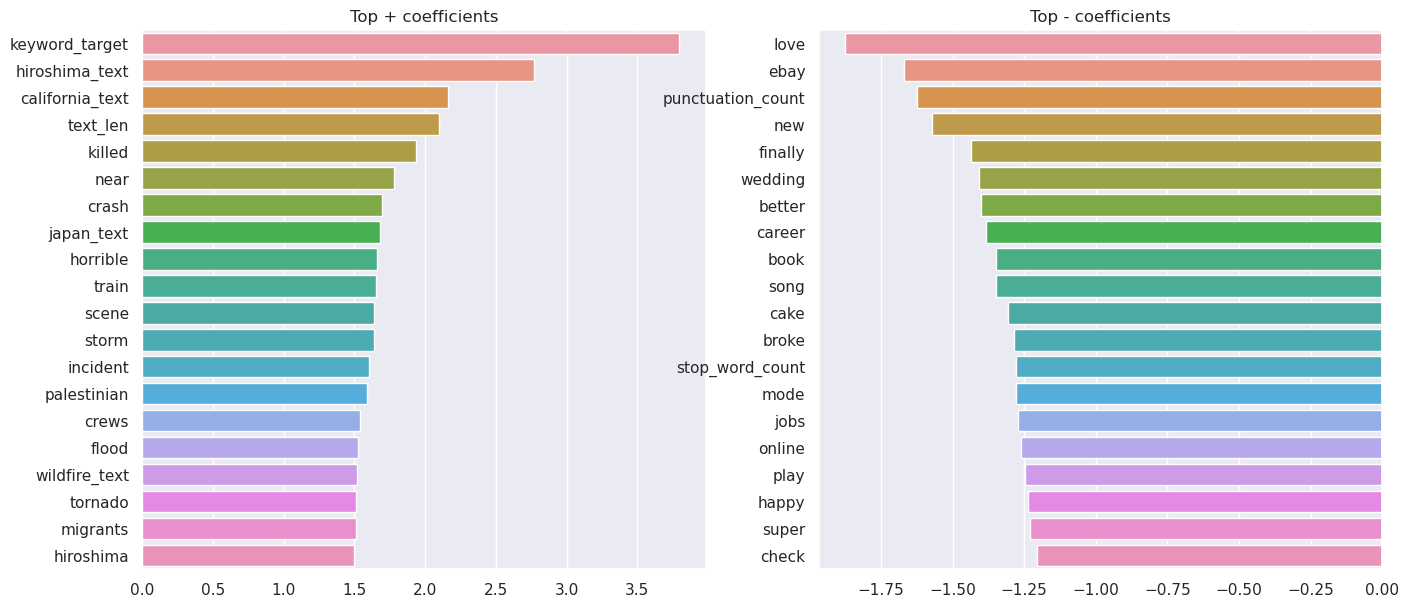

In [108]:
# Top features
plt.figure(figsize=(16,7))
s1 = pd.Series(np.transpose(lr.coef_[0]), index=X_train.columns).sort_values(ascending=False)[:20]
s2 = pd.Series(np.transpose(lr.coef_[0]), index=X_train.columns).sort_values()[:20]
plt.subplot(121)
sns.barplot(y=s1.index, x=s1)
plt.title('Top + coefficients')
plt.subplot(122)
sns.barplot(y=s2.index, x=s2)
plt.title('Top - coefficients')
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


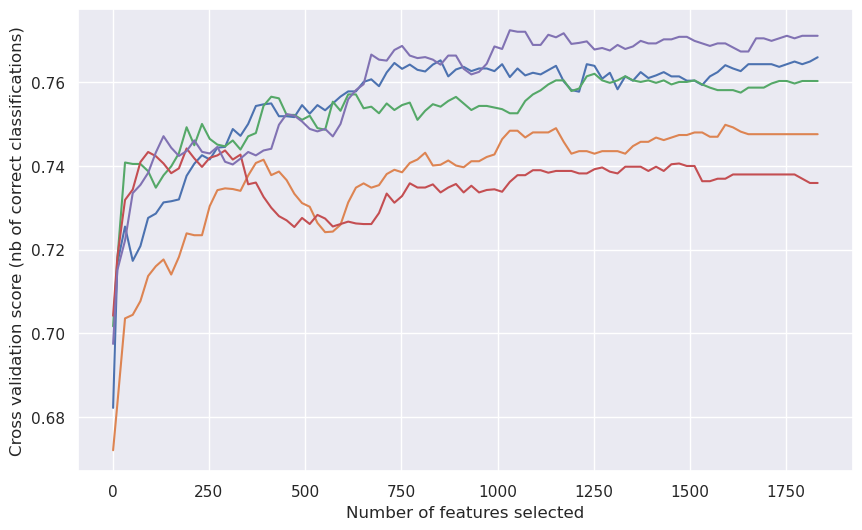

In [109]:
from sklearn.feature_selection import RFECV

steps = 20
n_features = len(X_train.columns)
X_range = np.arange(n_features - (int(n_features/steps)) * steps, n_features+1, steps)

rfecv = RFECV(estimator=lr, step=steps, cv=cv, scoring='f1')

pipeline2 = Pipeline([('scale',scaler), ('rfecv', rfecv)])
pipeline2.fit(X_train, y_train)
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(np.insert(X_range, 0, 1), rfecv.grid_scores_)
plt.show()

In [110]:
n_features = X_train.shape[1]
print('Optimal no. of features: %d' % n_features)

Optimal no. of features: 1832


In [113]:
selected_features = X_train.columns[rfecv.ranking_ == 1]
X_train2 = X_train[selected_features]
X_test2 = X_test[selected_features]
pipeline.fit(X_train2, y_train)
cv2 = ShuffleSplit(n_splits=5, test_size=0.2, random_state=456)
cv_score2 = cross_val_score(pipeline, X_train2, y_train, cv=cv2, scoring='f1')
print('Cross validation F-1 score: %.3f' %np.mean(cv_score2))

Cross validation F-1 score: 0.777


In [115]:
from sklearn.model_selection import GridSearchCV

grid={"C":np.logspace(-2,2,5), "penalty":["l1","l2"]}
lr_cv = GridSearchCV(LogisticRegression(solver='liblinear', random_state=20), grid, cv=cv2, scoring = 'f1')

pipeline_grid = Pipeline([('scale',scaler), ('gridsearch', lr_cv),])

pipeline_grid.fit(X_train2, y_train)

print("Best parameter: ", lr_cv.best_params_)
print("F-1 score: %.3f" %lr_cv.best_score_)

Best parameter:  {'C': 1.0, 'penalty': 'l2'}
F-1 score: 0.776


In [116]:
y_test2 = pipeline_grid.predict(X_test2)

# Use an existing sample submission file
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

submit2 = sample_submission.copy()
submit2.target = y_test2
submit2.to_csv('submit_lr2.csv',index=False)